### **Neural Collaborative Filtering**

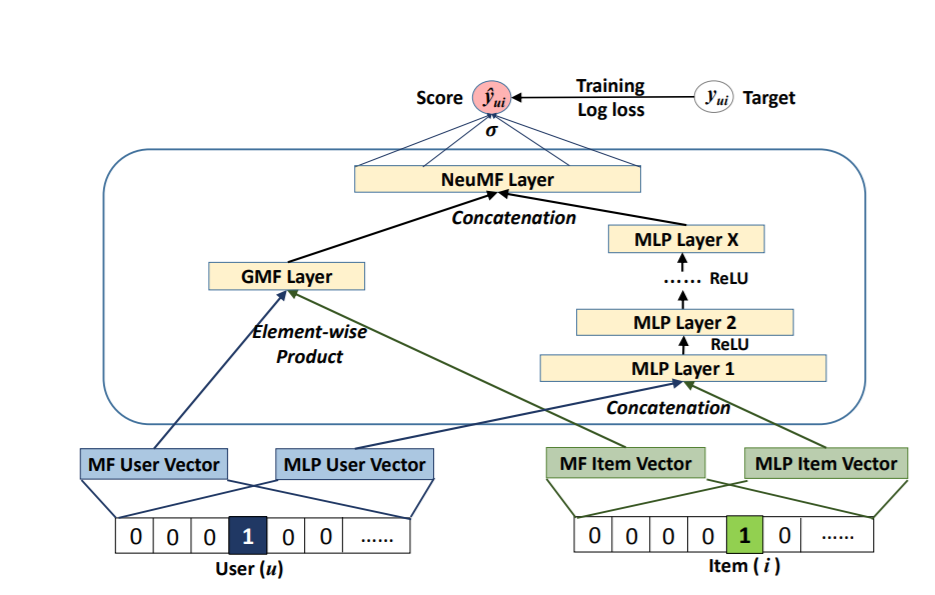

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers, regularizers

In [2]:
course_df = pd.read_csv('course_processed.csv')
course_df.head()

,COURSE_ID,TITLE,DESCRIPTION
0,ML0201EN,Robots Are Coming Build Iot Apps With Watson ...,Have Fun With Iot And Learn Along The Way If ...
1,ML0122EN,Accelerating Deep Learning With Gpu,Training Complex Deep Learning Models With Lar...
2,GPXX0ZG0EN,Consuming Restful Services Using The Reactive ...,Learn How To Use A Reactive Jax Rs Client To A...
3,RP0105EN,Analyzing Big Data In R Using Apache Spark,Apache Spark Is A Popular Cluster Computing Fr...
4,GPXX0Z2PEN,Containerizing Packaging And Running A Sprin...,Learn How To Containerize Package And Run A ...


In [3]:
def ncf_create(n_users: int, n_items: int,                           
               latent_dim_mf: int = 32, latent_dim_mlp: int = 32,   
               reg_mf: int = 0, reg_mlp: int = 0.001,                
               dense_layers: list = [16, 8, 4],                       
               reg_layers: list = [0.01, 0.01, 0.01],                    
               activation_dense: str = 'relu'                     
) -> keras.Model:

    user = keras.Input(shape=(), dtype='int32', name='user_id')
    item = keras.Input(shape=(), dtype='int32', name='item_id')

    mf_user_embedding = keras.layers.Embedding(input_dim = n_users,
                                  output_dim = latent_dim_mf,
                                  name = 'mf_user_embedding',
                                  embeddings_initializer = 'RandomNormal',
                                  embeddings_regularizer = regularizers.l2(reg_mf)
                                 )
    
    mf_item_embedding = keras.layers.Embedding(input_dim = n_items,
                                  output_dim = latent_dim_mf,
                                  name = 'mf_item_embedding',
                                  embeddings_initializer = 'RandomNormal',
                                  embeddings_regularizer = regularizers.l2(reg_mf)
                                 )

    mlp_user_embedding = keras.layers.Embedding(input_dim = n_users,
                                   output_dim = latent_dim_mlp,
                                   name = 'mlp_user_embedding',
                                   embeddings_initializer = 'RandomNormal',
                                   embeddings_regularizer = regularizers.l2(reg_mlp)
                                  )
    mlp_item_embedding = keras.layers.Embedding(input_dim = n_items,
                                  output_dim = latent_dim_mlp,
                                  name = 'mlp_item_embedding',
                                  embeddings_initializer = 'RandomNormal',
                                  embeddings_regularizer = regularizers.l2(reg_mlp)
                                 )

    mf_user_latent = keras.layers.Flatten()(mf_user_embedding(user))
    mf_item_latent = keras.layers.Flatten()(mf_item_embedding(item))

    mlp_user_latent = keras.layers.Flatten()(mlp_user_embedding(user))
    mlp_item_latent = keras.layers.Flatten()(mlp_item_embedding(item))

    mf_cat_latent = keras.layers.Multiply()([mf_user_latent, mf_item_latent])
    mlp_cat_latent = keras.layers.Concatenate()([mlp_user_latent, mlp_item_latent])

    mlp_vector = mlp_cat_latent
    for i in range(len(dense_layers)):
        layer = keras.layers.Dense(
                      units = dense_layers[i],
                      activation = activation_dense,
                      activity_regularizer = regularizers.l2(reg_layers[i]),
                      name = 'layer%d' % i,
                     )
        mlp_vector = layer(mlp_vector)
    
    predict_layer = keras.layers.Concatenate()([mf_cat_latent, mlp_vector])
    result = keras.layers.Dense(
                   units = 1, 
                   activation = 'sigmoid',
                   kernel_initializer = 'lecun_uniform',
                   name = 'interaction' 
                  )

    output = result(predict_layer)

    model = keras.Model(inputs = [user, item],
                  outputs = [output]
                 )

    return model

In [4]:
def ncf_data_prep(df: pd.DataFrame) -> pd.DataFrame:

    df_uim = (df.pivot(index='user', columns='item', values='rating')
            .reset_index()
            .rename_axis(columns=None, index=None)
            .fillna(0)
        )

    old_cols = df_uim.columns[1:]
    new_cols = [i for i in range(len(old_cols))]
    items_id2idx = {old_cols[i]: new_cols[i] for i in range(len(old_cols))}
    df_uim = df_uim.rename(mapper=items_id2idx, axis=1)

    original_user_ids = df_uim['user'].tolist()
    user_id2idx = {user_id: idx for idx, user_id in enumerate(original_user_ids)}
    df_uim['user'] = df_uim['user'].map(user_id2idx)

    df_train = (pd.DataFrame(df_uim.iloc[:, 1:].stack())
                .reset_index()
                .sort_values(by='level_0')
                .rename({'level_0': 'user_id', 'level_1': 'item_id', 0: 'interaction'}, axis=1)
               )
    df_train['interaction'] = df_train['interaction'].apply(lambda x: 1.0 if x > 0 else 0.0)

    df_train['user_id'] = df_train['user_id'].astype('int')
    df_train['item_id'] = df_train['item_id'].astype('int')
    df_train['interaction'] = df_train['interaction'].astype('float32')

    return df_train.sort_values(by=['user_id', 'item_id']), user_id2idx, items_id2idx

In [5]:
def ncf_build_train_val_dataset(df: pd.DataFrame, val_split: float = 0.1, batch_size: int = 512, rs: int = 42):
    
    df['user_id'] = df['user_id'].astype('int32')
    df['item_id'] = df['item_id'].astype('int32')
    df['interaction'] = df['interaction'].astype('float32')

    if rs:
        df = df.sample(frac=1, random_state=rs).reset_index(drop=True)

    n_val = round(len(df) * val_split)
    x = {
        'user_id': df['user_id'].values,
        'item_id': df['item_id'].values
    }
    y = df['interaction'].values

    ds = tf.data.Dataset.from_tensor_slices((x, y))

    ds_val = ds.take(n_val).batch(batch_size)
    ds_train = ds.skip(n_val).batch(batch_size)

    return ds_train, ds_val

In [6]:
def load_ratings():
    return pd.read_csv('ratings.csv')

In [7]:
def ncf_train_model(ds_train, ds_val, n_epochs: int = 10):

    n_users, n_items = (load_ratings()
                        .pivot(index='user', columns='item', values='rating')
                        .reset_index()
                        .rename_axis(index=None, columns=None)
                        .shape)
    
    ncf_model = ncf_create(n_users=n_users, n_items=n_items)
    ncf_model.compile(optimizer = "adam",
                    loss = 'binary_crossentropy',
                    metrics = [
                                tf.keras.metrics.TruePositives(name="tp"),
                                tf.keras.metrics.FalsePositives(name="fp"),
                                tf.keras.metrics.TrueNegatives(name="tn"),
                                tf.keras.metrics.FalseNegatives(name="fn"),
                                tf.keras.metrics.BinaryAccuracy(name="accuracy"),
                                tf.keras.metrics.Precision(name="precision"),
                                tf.keras.metrics.Recall(name="recall"),
                                tf.keras.metrics.AUC(name="auc"),
                                ]
                    )

    ncf_model._name = 'neural_collaborative_filtering'
    ncf_hist = ncf_model.fit(x=ds_train, 
                             validation_data=ds_val,
                             epochs=n_epochs,
                             verbose=1
                            )
    return ncf_model, ncf_hist

In [8]:
def NCF_train():

    df = load_ratings()
    df_train, user_id2idx, item_id2idx = ncf_data_prep(df)
    ds_train, ds_val = ncf_build_train_val_dataset(df=df_train, val_split=0.1, rs=42)

    model, _ = ncf_train_model(ds_train=ds_train, ds_val=ds_val, n_epochs=10)
    return model, df, user_id2idx, item_id2idx

model, df, user_id2idx, item_id2idx = NCF_train()

Epoch 1/10
7509/7509 ━━━━━━━━━━━━━━━━━━━━ 430s 57ms/step - accuracy: 0.9429 - auc: 0.7067 - fn: 99221.0938 - fp: 4360.7500 - loss: 0.3684 - precision: 0.3365 - recall: 0.0358 - tn: 1813719.5000 - tp: 5514.5083 - val_accuracy: 0.9535 - val_auc: 0.9206 - val_fn: 16854.0000 - val_fp: 3026.0000 - val_loss: 0.1289 - val_precision: 0.6861 - val_recall: 0.2818 - val_tn: 400660.0000 - val_tp: 6613.0000
Epoch 2/10
7509/7509 ━━━━━━━━━━━━━━━━━━━━ 389s 52ms/step - accuracy: 0.9581 - auc: 0.9397 - fn: 64628.8633 - fp: 14008.8672 - loss: 0.1140 - precision: 0.7329 - recall: 0.3617 - tn: 1804071.3750 - tp: 40106.7383 - val_accuracy: 0.9570 - val_auc: 0.9347 - val_fn: 13985.0000 - val_fp: 4390.0000 - val_loss: 0.1191 - val_precision: 0.6835 - val_recall: 0.4041 - val_tn: 399296.0000 - val_tp: 9482.0000
Epoch 3/10
7509/7509 ━━━━━━━━━━━━━━━━━━━━ 369s 49ms/step - accuracy: 0.9670 - auc: 0.9652 - fn: 48196.0430 - fp: 13421.3203 - loss: 0.0892 - precision: 0.8001 - recall: 0.5231 - tn: 1804659.0000 - tp: 5

In [9]:
def ncf_predict(model, trained_on, User_id, user_id2idx, item_id2idx) -> dict:

    df, _, _ = ncf_data_prep(trained_on)
    df = df[df['user_id'] == user_id2idx[User_id]]
    ds_pred, _ = ncf_build_train_val_dataset(df=df, val_split=0, rs=None)

    ncf_predictions = model.predict(ds_pred)
    df['ncf_prediction'] = ncf_predictions

    c_idx2id = {v: k for k, v in item_id2idx.items()}

    user_idx = user_id2idx[User_id]
    interacted_items = df.loc[(df['user_id'] == user_idx) & (df['interaction'] == 1), 'item_id']

    enrolled_courses = []
    
    for item_idx in interacted_items:
        enrolled_courses.append(c_idx2id[item_idx])

    df['item_id'] = df['item_id'].map(c_idx2id)
    df = df.reset_index().drop('index', axis=1)
    r = {}
    for i in range(df.shape[0]):
        if not (df['item_id'][i] in enrolled_courses):
            r[df.loc[i, 'item_id']] = df.loc[i, 'ncf_prediction'] * 100
            
    r = {k: v for k, v in sorted(r.items(), key=lambda item: item[1], reverse=True)}
    return r

In [10]:
similarity = ncf_predict(model, df, 2, user_id2idx, item_id2idx)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [11]:
n_rec = 5
users = []
courses = []
titles = []
scores = []
res_dict = {}

for key, score in similarity.items():
    courses.append(key)
    titles.append(course_df['TITLE'][course_df['COURSE_ID'] == key].values[0].title())
    scores.append(score)
    
res_dict['COURSE_ID'] = courses
res_dict['TITLE'] = titles
res_dict['SCORE'] = scores
res_df = pd.DataFrame(res_dict, columns=['COURSE_ID', 'TITLE', 'SCORE'])
res_df[:n_rec]

,COURSE_ID,TITLE,SCORE
0,DB0151EN,Nosql And Dbaas 101,99.999970
1,ML0151EN,Machine Learning With R,83.889848
2,BD0115EN,Mapreduce And Yarn,74.078274
3,BC0202EN,Build An Iot Blockchain Network For A Supply C...,44.429490
4,WA0103EN,Watson Analytics For Social Media,29.323769
